# Bayes Inference cheatsheet
When performing Bayesian Inference, there are numerous ways to solve, or approximate, a posterior distribution. Usually an author of a book or tutorial will choose one, or they will present both but many chapters apart. This notebook solves the same problem each way all in Python. References are provided for each method for further exploration as well.

## Another great reference
Chapter 8 of [Osvaldo Martin's book](https://www.packtpub.com/big-data-and-business-intelligence/bayesian-analysis-python-second-edition) contains a more in depth overview of the methods below. I highly reccomend reaeding it as well, particularly if you would like a deeper understanding of each method.


In [1]:
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import pystan
import arviz as az

## The problem
What is the proportion of water on the globe, given measurements of random tosses?
This question is taken from Richard McElreath's books and his lecture. A video explanation can be found here.

[Proportion of Water on a Globe](https://youtu.be/XoVtOAN0htU?t=278)

### Problem definition in Python
Usually this is done with numpy arrays, where water and land is encoded with 0 and 1 for success. I'm doing it here in two steps to highlight that the ones and zeros just stand for success and failure

In [2]:
observations = pd.Series(["w", "l", "w", "w", "w","l","w", "l", "w"])

# Convert to binomial representation
observations_binom = (observations == "w").astype(int).values
observations_binom

array([1, 0, 1, 1, 1, 0, 1, 0, 1])

In [3]:
water_observations = sum(observations_binom)
total_observations = len(observations_binom)

# Inference
There are multiple ways of doing inference, even more than the ones here. For each method there is an example, reference links, and short list of pros and cons.

## Conjugate Prior
Conjugate priors are the "original" way of solving Bayes rule. Conjurage priors are analytical solutions, meaning that a good (probably great) mathematician was able to create a closed form solution by hand. For our Beta Binominal water tossing problem we can use the formula here and magically get the solution.

## Reference
https://en.wikipedia.org/wiki/Conjugate_prior

In [4]:
_alpha = 1 + water_observations
_beta = 1 + total_observations - water_observations

Text(0.5, 0.98, 'Exact Posterior through Conjugate Prior')

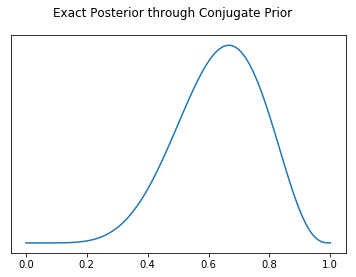

In [5]:
x = np.linspace(0,1,100)
posterior_conjugate = stats.beta.pdf(x, a=_alpha, b=_beta)

fig, ax = plt.subplots()
plt.plot(x,posterior_conjugate)
ax.set_yticks([])
fig.suptitle("Exact Posterior through Conjugate Prior")

In [6]:
posterior_conjugate[40] / posterior_conjugate[70]

0.2931796007669374

### Conjugate Prior Pros
* Posterior distribution is exact. It is *not* an estimation
* Most computationally efficient

### Conjugate Prior Cons
* Requires advanced math skills to get analytical solution
* Only simple problems have been solved (https://en.wikipedia.org/wiki/Conjugate_prior#Table_of_conjugate_distributions)

## Grid Search
Steps
1. Generate a grid of points
2. Calculate likelihood for each point
3. For each beta take another grid of points to get probability
4. Calculate likelihood and posterior

**Statistical Rethinking** Chapter 3 contains a great overview of Grid Search

In [7]:
possible_probabilities = np.linspace(0,1,100)
prior = np.repeat(5,100)
likelihood = stats.binom.pmf(water_observations, total_observations, possible_probabilities)

posterior_unstandardized = likelihood * prior
posterior_grid_search = posterior_unstandardized / sum(posterior_unstandardized)

Text(0.5, 0.98, 'Posterior through Grid Approximation')

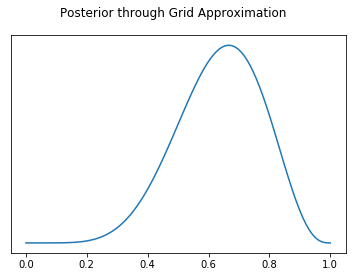

In [8]:
fig, ax = plt.subplots()
plt.plot(possible_probabilities, posterior_grid_search)
ax.set_yticks([])
fig.suptitle("Posterior through Grid Approximation")

In [9]:
posterior_grid_search[40] / posterior_grid_search[70]

0.29317960076693733

### Grid Search Pros
* Conceptually simple
* Can theoretically be used to solve any problems

### Grid Search Cons
* Combinatorics will mean that solution scales very poorly. The sun will explode before inference is completed on most models

## Quadratic (Laplace) Approximation
http://www.sumsar.net/blog/2013/11/easy-laplace-approximation/  
https://github.com/pymc-devs/resources/blob/master/Rethinking/Chp_02.ipynb

Chapter 8 of Bayesian Analysis in Python
https://www.packtpub.com/big-data-and-business-intelligence/bayesian-analysis-python-second-edition

In [10]:
with pm.Model() as normal_aproximation:
    p = pm.Uniform('p', 0, 1)
    w = pm.Binomial('w', n=total_observations, p=p, observed=water_observations)
    mean_q = pm.find_MAP()
    std_q = ((1/pm.find_hessian(mean_q, vars=[p]))**0.5)[0]
mean_q['p'], std_q

/Users/canyon/.miniconda3/envs/arviz/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -1.8075, ||grad|| = 1.5: 100%|██████████| 7/7 [00:00<00:00, 438.68it/s]


(array(0.66666667), array([0.15713484]))

Text(0.5, 0.98, 'Posterior Approximation through Quadratic Approximation')

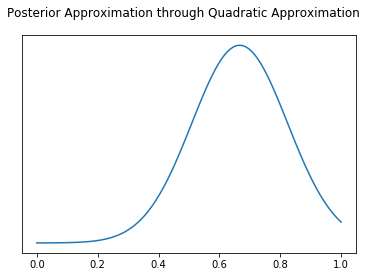

In [11]:
possible_probabilities = np.linspace(0,1,100)
posterior_laplace = stats.norm.pdf(possible_probabilities, mean_q['p'], std_q)
fig, ax = plt.subplots()
ax.set_yticks([])
plt.plot(possible_probabilities, posterior_laplace)
fig.suptitle("Posterior Approximation through Quadratic Approximation")

In [12]:
posterior_laplace[40] / posterior_laplace[70]

0.255729157826732

### Laplace Approximation Pros
* Relatively fast compared to methods such as MCMC or ADVI

### Laplace Approximation Cons
* Normal distributions can't approximate everything, for example bimodel distributions

## Markov Chain Monte Carlo
Markov Chain Monte Carlo (MCMC) is a way approximate a posterior distribution by sampling from the posterior distribution. I found the visualizations in the link below make it easier to see what this means. The advances in MCMC are coming from advances in samplers. The No U Turn Sampler (NUTS) for example is one of the most widely popular at the moment, since it can "find" good samples more often than older samples such as Metropolis Hastings.

There are many bayesian libraries in addition to the two shown here.

### "Hand built" Metroplis Hastings
https://twiecki.io/blog/2015/11/10/mcmc-sampling/  
http://elevanth.org/blog/2017/11/28/build-a-better-markov-chain/

In [13]:
samples = 5000
proposal_width = .1
p_accept = .5

# Assume Normal Prior for this example
p_water_current = .5
p_water_prior_normal_mu = .5
p_water_prior_normal_sd = 1

mh_posterior = []
for i in range(samples):
    # Proposal Normal distribution
    p_water_proposal = stats.norm(p_water_current, proposal_width).rvs()
    
    # Calculate likelihood of each
    likelihood_current = stats.binom.pmf(water_observations, total_observations, p_water_current)
    likelihood_proposal = stats.binom.pmf(water_observations, total_observations, p_water_proposal)

    # Convert likelihoods that evaluate to nans to zero
    likelihood_current = np.nan_to_num(likelihood_current)
    likelihood_proposal = np.nan_to_num(likelihood_proposal)
    
    # Calculate prior value given proposal and current
    prior_current = stats.norm(p_water_prior_normal_mu, p_water_prior_normal_sd).pdf(p_water_current)
    prior_proposal = stats.norm(p_water_prior_normal_mu, p_water_prior_normal_sd).pdf(p_water_proposal)

    # Calculate posterior probability of current and proposals
    p_current = likelihood_current * prior_current
    p_proposal = likelihood_proposal * prior_proposal
    
    p_accept = p_proposal / p_current
    
    if np.random.rand() < p_accept:
        p_water_current = p_water_proposal
    
    assert p_water_current > 0

    mh_posterior.append(p_water_current)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c2ae2b710>],
      dtype=object)

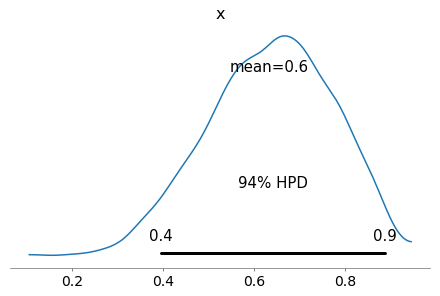

In [14]:
mh_posterior= np.asarray(mh_posterior)
az.plot_posterior(mh_posterior)

In [15]:
np.asarray(mh_posterior)

array([0.52734122, 0.65863867, 0.65863867, ..., 0.75479234, 0.60754154,
       0.60391625])

### Estimate local probability
Because MCMC provides samples and not an actual distribution, we have to take a ratio of counts, not a ratio of areas as before

In [16]:
def estimate_prob_ratio_from_samples(mcmc_posterior, prob_1=possible_probabilities[40],
                                     prob_2=possible_probabilities[70], width=.01):
    
    # We need to compare the same interval in the distribution as we did above
    # In the above case x[20] is .01 wide centered at 
    num_samples_1 = np.sum(np.isclose(prob_1, mcmc_posterior, rtol=0, atol=width))
    num_samples_2 = np.sum(np.isclose(prob_2, mcmc_posterior, rtol=0, atol=width))
    return num_samples_1 / num_samples_2
    
estimate_prob_ratio_from_samples(mh_posterior)

0.25252525252525254

## PyMC3 MCMC Hamilton Monte Carlo (Specifically Nuts)
Probabilistic Programming languages simplify Bayesian modeling tremendously but letting letting the statistician focus on the model, and less so on the sampler or other mathematical details. From a s

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]
INFO:pymc3:NUTS: [p]
Sampling 2 chains: 100%|██████████| 101000/101000 [02:56<00:00, 570.75draws/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c2d2265c0>],
      dtype=object)

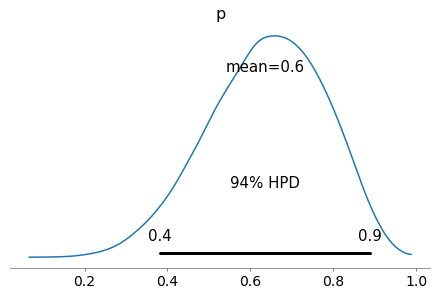

In [17]:
with pm.Model() as mcmc_nuts:
    p_water = pm.Uniform("p", 0 ,1)
    w = pm.Binomial("w", p=p_water, n=total_observations, observed=water_observations)
    trace = pm.sample(50000, chains=2)
    
az.plot_posterior(trace)

In [19]:
pymc3_samples = trace.get_values("p")
estimate_prob_ratio_from_samples(pymc3_samples)

0.2939352838597171

## Stan MCMC Hamilton Monte Carlo (Also Nuts)
We can build the same model in Stan as well, in this case pystan, which is a python interface to Stan.


In [20]:
water_code = """
data {
    int<lower=0> water_observations; // number of water observations
    int<lower=0> number_of_tosses; // number of globe tosses
}

parameters {
    real p_water; // Proportion of water on globe
}

model {
    p_water~uniform(0.0,1.0);
    water_observations ~ binomial(number_of_tosses, p_water);
}
"""
water_dat = {'water_observations': 6,
               'number_of_tosses': 9}

sm = pystan.StanModel(model_code=water_code)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dedfcbf67db9d2d5064f58308236c51b NOW.


In file included from /var/folders/gt/28pvdm614vd_2tn01llmx3s00000gp/T/tmplfgnb5v3/stanfit4anon_model_dedfcbf67db9d2d5064f58308236c51b_6981221221787175261.cpp:642:
In file included from /Users/canyon/.miniconda3/envs/arviz/lib/python3.6/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /Users/canyon/.miniconda3/envs/arviz/lib/python3.6/site-packages/numpy/core/include/numpy/ndarrayobject.h:18:
In file included from /Users/canyon/.miniconda3/envs/arviz/lib/python3.6/site-packages/numpy/core/include/numpy/ndarraytypes.h:1823:
/Users/canyon/.miniconda3/envs/arviz/lib/python3.6/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: "Using deprecated NumPy API, disable it by "          "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it by " \
 ^
1 warning generated.
ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: ignoring file /Li

In [21]:
fit = sm.sampling(data=water_dat, iter=50000, chains=4)

In [22]:
stan_samples = fit["p_water"]
estimate_prob_ratio_from_samples(stan_samples)

0.2915390505359878

## Markov Monte Carlo Chain Pros
* MCMC seems to be most popular method at time of writing
* Popular libraries such as Stan, PyMC3, emcee, Pyro, use MCMC as main inference engine

## PyMC3 Variational Inference (Specifically Automatic Differentiation Variational Inference)
In short Variational Inference iteratively converts a model into an unconstrained space, then tries to optimize the Kullback-Leibler divergence. A great explanation of the exact steps can be found at the bottom of page 3 below.

http://www.jmlr.org/papers/volume18/16-107/16-107.pdf  
https://www.cs.toronto.edu/~duvenaud/papers/blackbox.pdf  
https://arxiv.org/pdf/1601.00670.pdf

Average Loss = 2.3092: 100%|██████████| 50000/50000 [01:26<00:00, 576.23it/s]
Finished [100%]: Average Loss = 2.3102
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 2.3102


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c2f77ca58>],
      dtype=object)

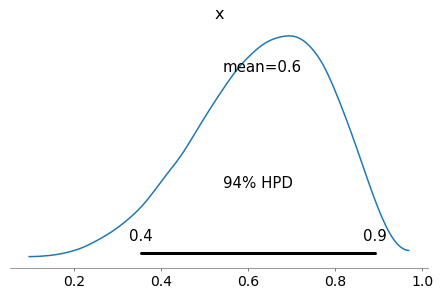

In [23]:
with pm.Model() as advi:
    p_water = pm.Uniform("p", 0 ,1)
    w = pm.Binomial("w", p=p_water, n=total_observations, observed=water_observations)
    mean_field = pm.fit(method='advi', n=50000)

advi_samples = mean_field.sample(50000).get_values("p")
az.plot_posterior(advi_samples)

In [24]:
estimate_prob_ratio_from_samples(advi_samples)

0.358148893360161

### Variational Inference Pros
* No sampling required unlike MCMC
* Able to handle complex models
* Scales to large amounts of data better than MCMC
* Faster than MCMC

### Variational Inference Cons
* Not guaranteed to reach "optimal" KL Diverence


# Other Inference Methods
There are other Bayesian methods that I frankly don't know enough about to write a full treatement here. I will list the ones I do know about however.
* Approximate Bayesian Computing